# Imports

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from matplotlib import ticker
import seaborn as sns
import warnings
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
from lightgbm import LGBMClassifier


# options
warnings.filterwarnings('ignore')

# Data

In [23]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

# Exploratory Data Analysis (Basic EDA)

In [24]:
train.head()

,ID,sequence1,sequence2,sequence3,sequence4,sequence5,sequence6,sequence7,sequence8,sequence9,...,M,N,O,P,Q,R,S,T,U,mutation
0,0,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,AAATCAGCTAAA,ATTCCATATTTT,ATTCCATATTTT,AAATCAGCTAAA,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,2,ATGCGCTTAATT,ATGCGCTTAATT,GATCGTAGCTAA,ATGCGCTTAATT,ATGCGCTTAATT,AAATCAGCTAAA,ATTCCATATTTT,ATTCCATATTTT,AAATCAGCTAAA,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
2,5,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,AAATCAGCTAAA,ATTCCATATTTT,ATTCCATATTTT,AAATCAGCTAAA,...,0.524760,0.580085,0.301498,0.261055,0.193988,0.935688,0.685868,0.277694,0.428115,0
3,7,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATTCCATATTTT,AAATCAGCTAAA,TAACATACAGAG,TAACATACAGAG,...,0.943545,0.209744,0.670577,0.772650,0.845751,0.507320,0.927204,0.605755,0.454155,1
4,9,ATGCGCTTAATT,GATCGTAGCTAA,ATGCGCTTAATT,GATCGTAGCTAA,GATCGTAGCTAA,ATTCCATATTTT,AAATCAGCTAAA,ATTCCATATTTT,TAACATACAGAG,...,0.397622,0.506096,0.200673,0.734145,0.521673,0.365571,0.416094,0.584799,0.447149,1


Exploring data

In [25]:
#train['sequence1'].value_counts()
train['sequence2'].value_counts()
train['sequence3'].value_counts()
train['mutation'].value_counts()
#ATGCGCTTAATT
#GATCGTAGCTAA

0    132318
1     47682
Name: mutation, dtype: int64

from .info() we can see that there are no null values

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 32 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ID         180000 non-null  int64  
 1   sequence1  180000 non-null  object 
 2   sequence2  180000 non-null  object 
 3   sequence3  180000 non-null  object 
 4   sequence4  180000 non-null  object 
 5   sequence5  180000 non-null  object 
 6   sequence6  180000 non-null  object 
 7   sequence7  180000 non-null  object 
 8   sequence8  180000 non-null  object 
 9   sequence9  180000 non-null  object 
 10  A          180000 non-null  int64  
 11  B          180000 non-null  int64  
 12  C          180000 non-null  int64  
 13  D          180000 non-null  int64  
 14  E          180000 non-null  int64  
 15  F          180000 non-null  int64  
 16  G          180000 non-null  int64  
 17  H          180000 non-null  int64  
 18  I          180000 non-null  int64  
 19  J          180000 non-n

mutation is a binary target

In [27]:
train['mutation'].value_counts()

0    132318
1     47682
Name: mutation, dtype: int64

In [28]:
train.shape
train.describe()

,ID,A,B,C,D,E,F,G,H,I,...,M,N,O,P,Q,R,S,T,U,mutation
count,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,...,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000
mean,150259.572350,8.118989,2.632989,0.617833,4.802733,29.696178,1.262467,23.543444,33.423717,1.605150,...,0.516286,0.474217,0.505086,0.501836,0.487837,0.501700,0.487640,0.469766,0.507951,0.264900
std,86591.625009,3.078097,4.147355,1.191218,1.514448,12.700896,2.109440,13.897618,18.991241,2.752459,...,0.214696,0.216486,0.227391,0.241277,0.211201,0.203394,0.178990,0.194466,0.203378,0.441281
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.099276,-0.045316,0.169495,-0.033695,0.005199,0.093056,0.024139,0.215575,0.097789,0.000000
25%,75313.750000,7.000000,0.000000,0.000000,4.000000,33.000000,0.000000,9.000000,19.000000,0.000000,...,0.325804,0.291995,0.279693,0.276133,0.323797,0.353174,0.358795,0.310106,0.367429,0.000000
50%,150321.000000,8.000000,0.000000,0.000000,4.000000,33.000000,0.000000,23.000000,38.000000,0.000000,...,0.471377,0.388573,0.480476,0.554751,0.517962,0.435187,0.410841,0.408567,0.446227,0.000000
75%,225293.250000,10.000000,3.000000,1.000000,5.000000,33.000000,2.000000,35.000000,49.000000,2.000000,...,0.704146,0.645087,0.725755,0.735208,0.607613,0.642035,0.611452,0.587050,0.581691,1.000000
max,299999.000000,14.000000,18.000000,12.000000,19.000000,83.000000,15.000000,50.000000,60.000000,18.000000,...,1.016600,0.951018,0.856975,0.853022,0.960912,1.035818,1.054257,1.005652,1.011331,1.000000


In [29]:
test.head()

,ID,sequence1,sequence2,sequence3,sequence4,sequence5,sequence6,sequence7,sequence8,sequence9,...,L,M,N,O,P,Q,R,S,T,U
0,1,ATGCGCTTAATT,ATGCGCTTAATT,GATCGTAGCTAA,ATGCGCTTAATT,GATCGTAGCTAA,ATTCCATATTTT,AAATCAGCTAAA,ATTCCATATTTT,AAATCAGCTAAA,...,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729
1,3,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,AAATCAGCTAAA,ATTCCATATTTT,ATTCCATATTTT,AAATCAGCTAAA,...,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242
2,4,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,GATCGTAGCTAA,AAATCAGCTAAA,AAATCAGCTAAA,ATTCCATATTTT,AAATCAGCTAAA,...,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960
3,6,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,GATCGTAGCTAA,ATTCCATATTTT,ATTCCATATTTT,ATTCCATATTTT,AAATCAGCTAAA,...,0.707840,0.678466,0.747125,0.678212,0.553609,0.281719,0.768782,0.688580,0.320699,0.642256
4,8,GATCGTAGCTAA,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,ATGCGCTTAATT,AAATCAGCTAAA,ATTCCATATTTT,ATTCCATATTTT,AAATCAGCTAAA,...,0.664718,0.635195,0.672264,0.561127,0.419873,0.508550,0.673267,0.356103,0.471519,0.499554


In [30]:
submission.head()


,ID,mutation
0,1,0.5
1,3,0.5
2,4,0.5
3,6,0.5
4,8,0.5


* training data continous features distribution.

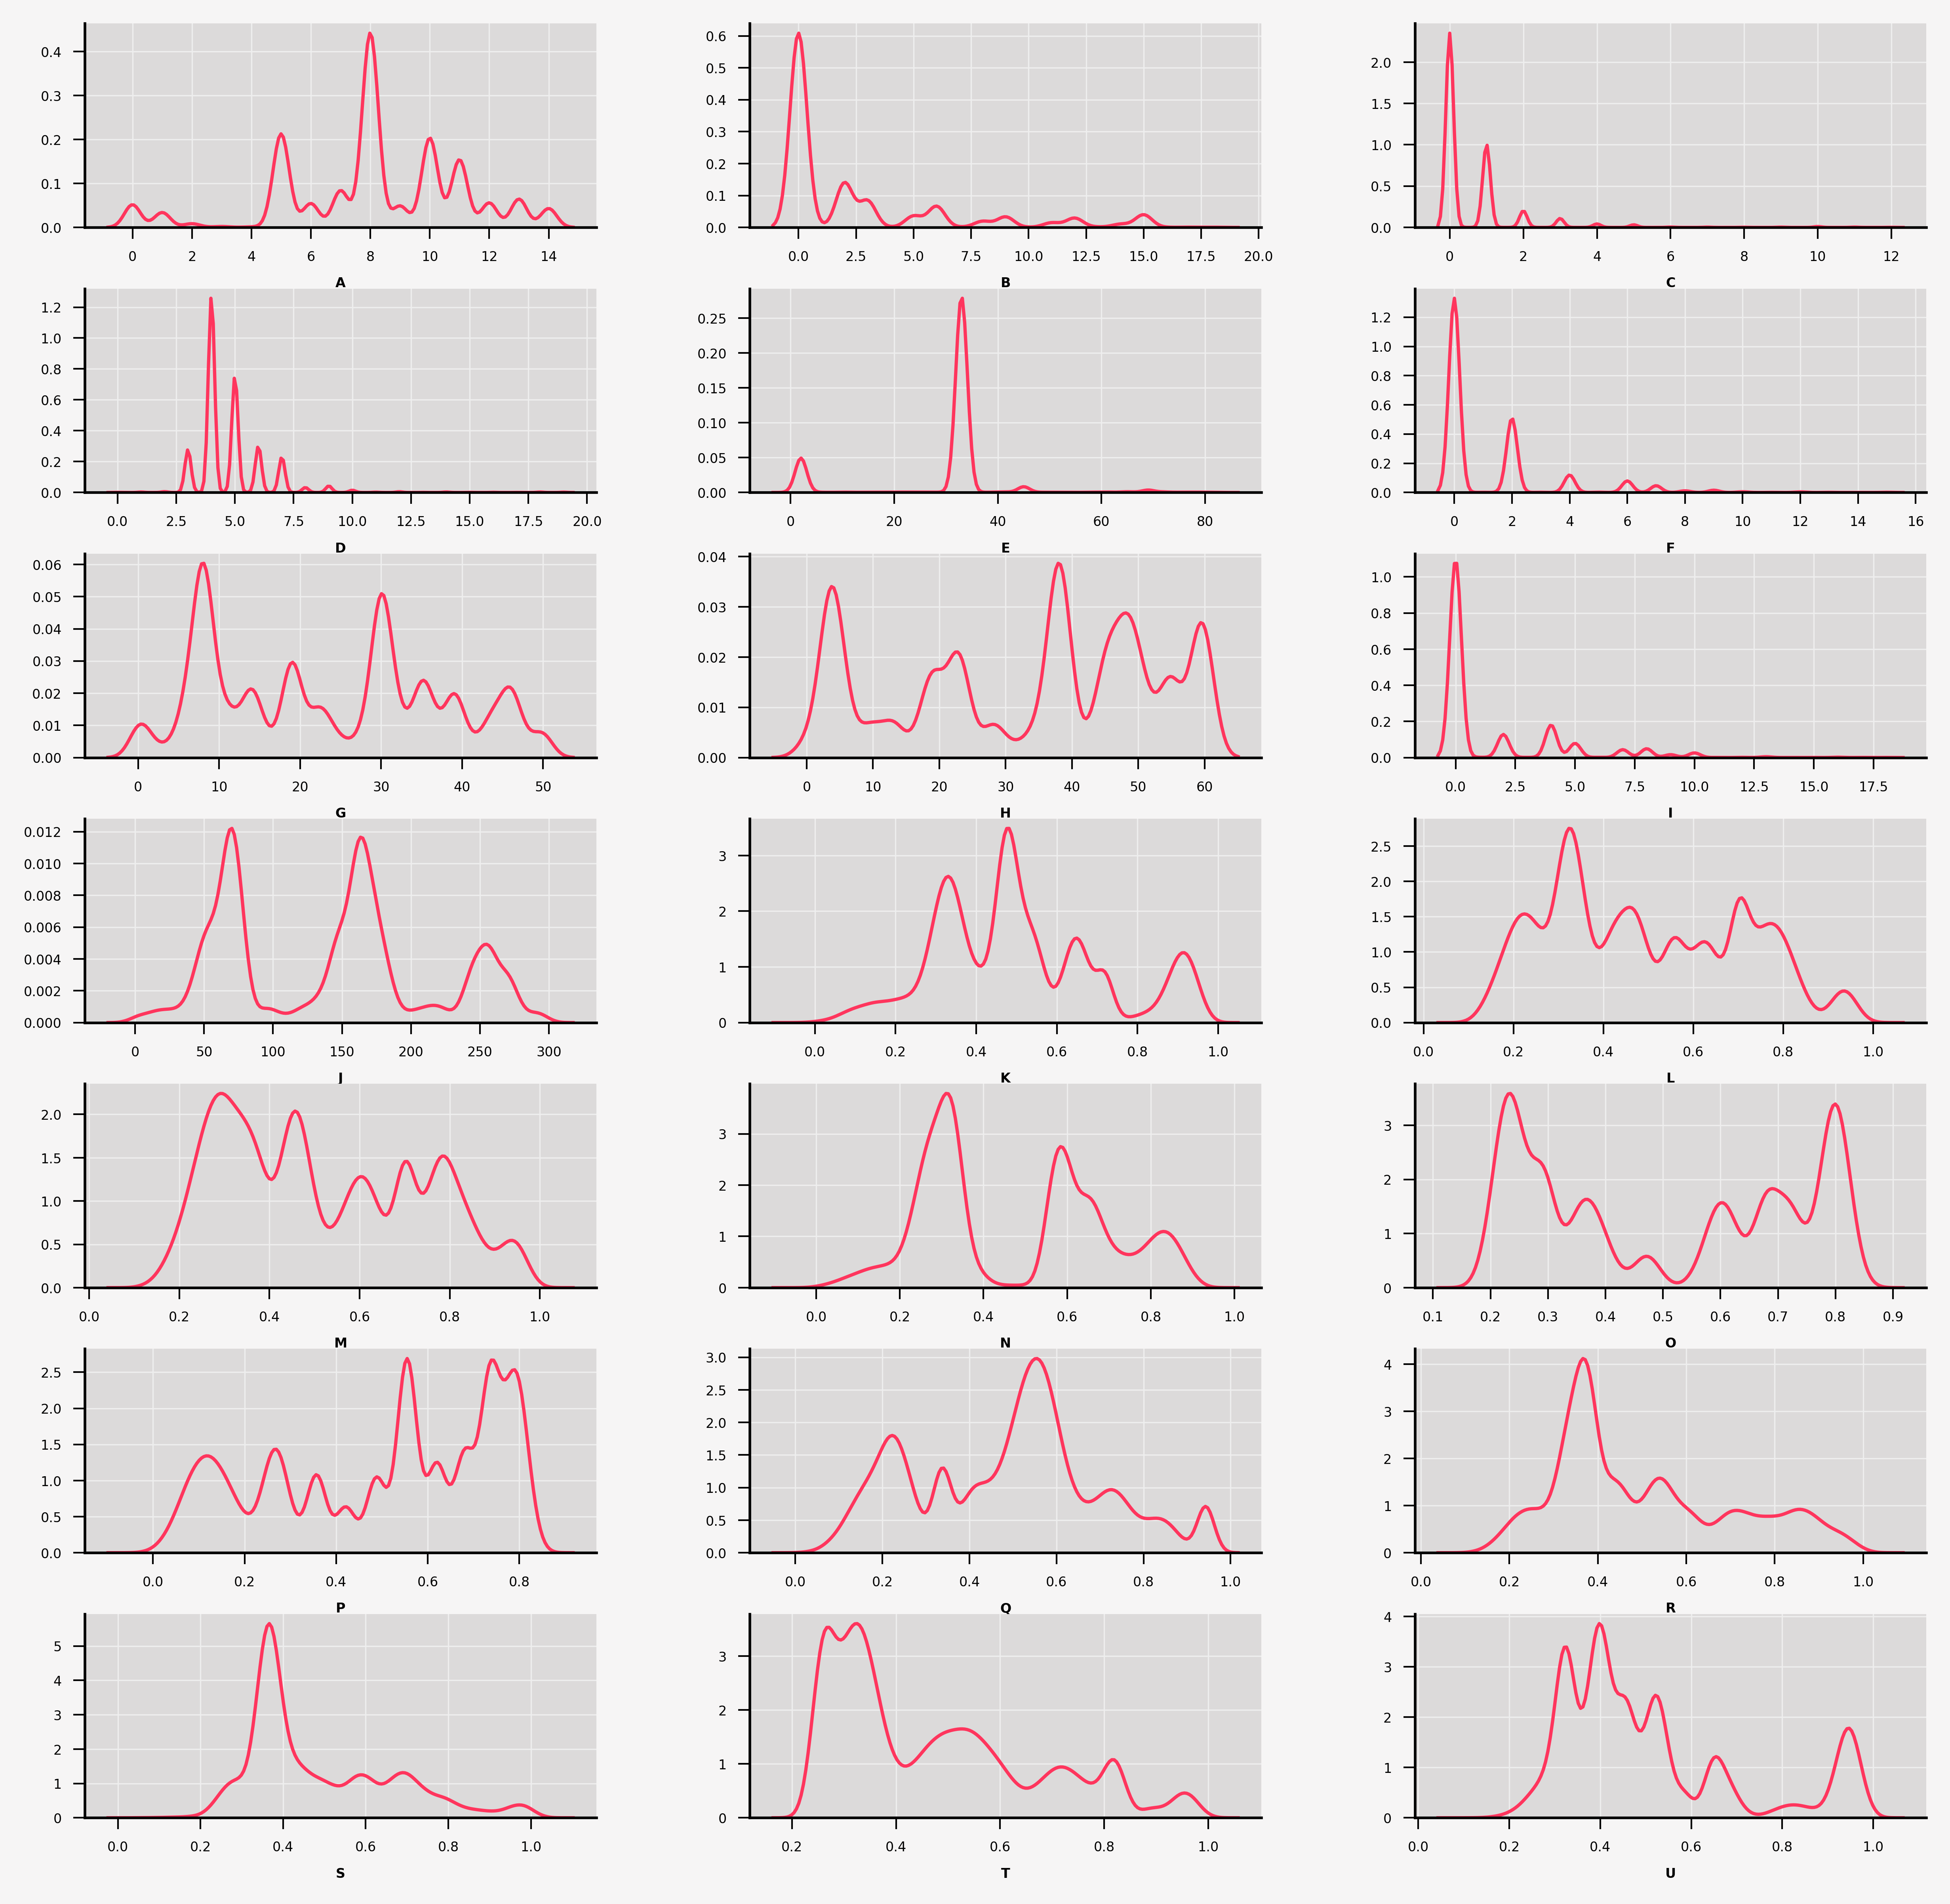

In [31]:
plt.rcParams['figure.dpi'] = 600
fig = plt.figure(figsize=(10, 10), facecolor='#f6f5f5')
gs = fig.add_gridspec(7, 3)
gs.update(wspace=0.3, hspace=0.3)
background_color = "#dcdada"

run_no = 0
for row in range(0, 7):
    for col in range(0, 3):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        for s in ["top","right"]:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1  

features_num = list([col for col in train.select_dtypes(exclude=object).columns if col not in ['ID', 'mutation']])

run_no = 0
for col in features_num:
    sns.kdeplot(ax=locals()["ax"+str(run_no)], x=train[col], zorder=2, alpha=1, linewidth=1, color='#FF355D')
    locals()["ax"+str(run_no)].grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
    locals()["ax"+str(run_no)].grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
    locals()["ax"+str(run_no)].set_ylabel('')
    locals()["ax"+str(run_no)].set_xlabel(col, fontsize=4, fontweight='bold')
    locals()["ax"+str(run_no)].tick_params(labelsize=4, width=0.5)
    locals()["ax"+str(run_no)].xaxis.offsetText.set_fontsize(4)
    locals()["ax"+str(run_no)].yaxis.offsetText.set_fontsize(4)
    run_no += 1

plt.show()

# checking correlations

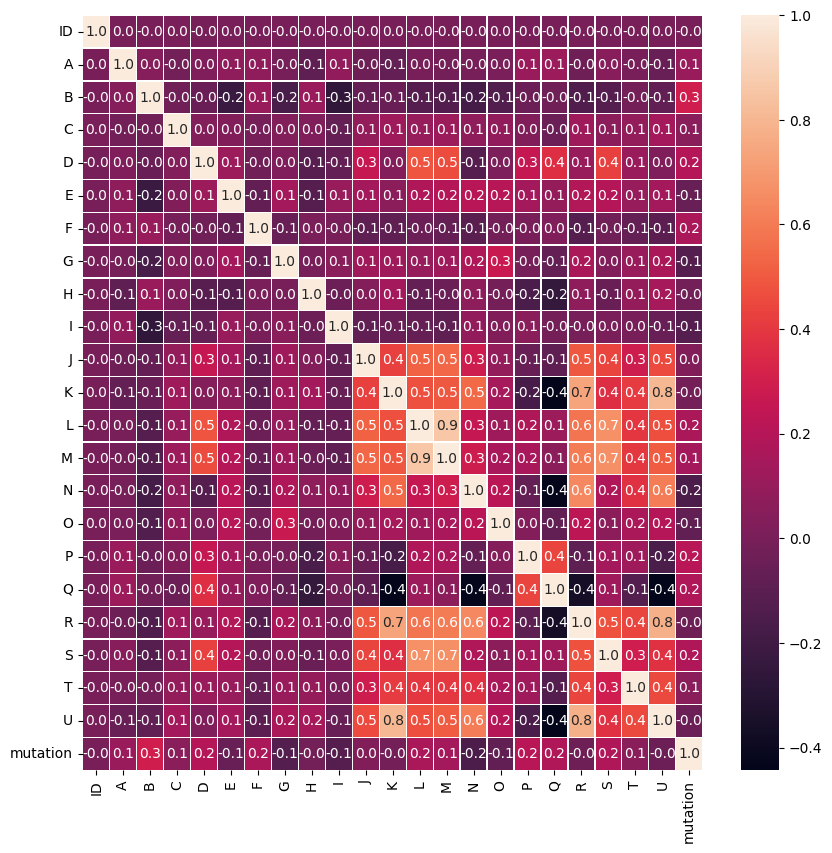

In [46]:
f,ax = plt.subplots(figsize=(10,10))
sns.heatmap(train.corr(), annot = True,linewidths=.2, fmt='.1f', ax=ax)

training data target label distribution.

<Figure size 500x500 with 0 Axes>

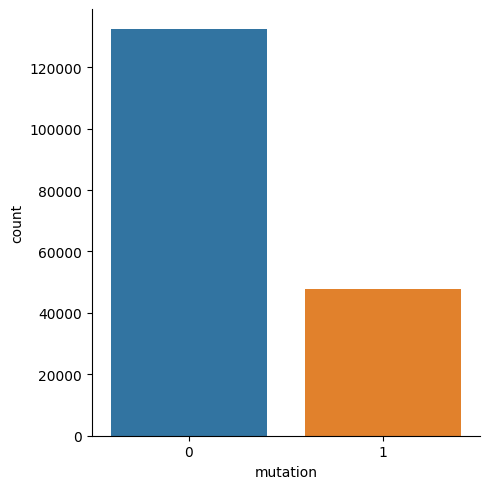

In [33]:
plt.rcParams['figure.dpi'] = 100
fig = plt.figure(figsize=(5, 5), facecolor='#f6f5f5')
background_color = "#dcdada"
fig = sns.catplot(x="mutation",data=train, kind="count")

# Training

In [34]:
def encoder(x_train, x_test):
    le = LabelEncoder()
    r = le.fit_transform(x_train)
    r2 = le.transform(x_test)
    return r, r2

In [35]:
features_cat = [col for col in train.columns if col in train.select_dtypes(include=object).columns]
features = [col for col in train.columns if col not in ['ID', 'mutation']]
print(f'total features: {len(features)}')
print(features)

total features: 30
['sequence1', 'sequence2', 'sequence3', 'sequence4', 'sequence5', 'sequence6', 'sequence7', 'sequence8', 'sequence9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U']


In [36]:
X, y = train.loc[:, features], train.loc[:, 'mutation']
print(X.shape)
print(y.shape)

(180000, 30)
(180000,)


In [37]:
# encoding categorical features
for col in features_cat:
    X.loc[:, col], test.loc[:, col] = encoder(X.loc[:, col], test.loc[:, col])

In [38]:
X.head()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 30 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   sequence1  180000 non-null  int64  
 1   sequence2  180000 non-null  int64  
 2   sequence3  180000 non-null  int64  
 3   sequence4  180000 non-null  int64  
 4   sequence5  180000 non-null  int64  
 5   sequence6  180000 non-null  int64  
 6   sequence7  180000 non-null  int64  
 7   sequence8  180000 non-null  int64  
 8   sequence9  180000 non-null  int64  
 9   A          180000 non-null  int64  
 10  B          180000 non-null  int64  
 11  C          180000 non-null  int64  
 12  D          180000 non-null  int64  
 13  E          180000 non-null  int64  
 14  F          180000 non-null  int64  
 15  G          180000 non-null  int64  
 16  H          180000 non-null  int64  
 17  I          180000 non-null  int64  
 18  J          180000 non-null  int64  
 19  K          180000 non-n

In [39]:
# initializing classifier
#clf = GaussianNB()
#clf=LogisticRegression()
#clf= XGBClassifier()
clf= LGBMClassifier()

# training
clf.fit(X, y)



LGBMClassifier()

# Submission and Prediction

* **predict_proba** is used instead of the typical **predict** method, this is due to the evaluation metric being the *area under the Roc curve*.

In [40]:
#FINAL PREDICTION
pred = clf.predict_proba(test[features])
pred = pred[:, 1]
pred


array([0.32078165, 0.09304922, 0.26944426, ..., 0.63160474, 0.0402699 ,
       0.58828004])

checking accuracy using log loss and brier metrics:

In [41]:
#for understanding splitting training data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25)
clf.fit(train_X, train_y)


LGBMClassifier()

In [50]:
#for undertsanding purpose
pred1 = clf.predict_proba(test_X)
pred1

array([[0.91923336, 0.08076664],
       [0.94179268, 0.05820732],
       [0.84355485, 0.15644515],
       ...,
       [0.94269573, 0.05730427],
       [0.31183192, 0.68816808],
       [0.92326125, 0.07673875]])

In [54]:
from sklearn.metrics import accuracy_score
y_pred=clf.predict(test_X)
accuracy=accuracy_score(y_pred,test_y)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_pred,test_y)))

LightGBM Model accuracy score: 0.8479


In [43]:
#compared log_loss and brier values for different models
loss= log_loss(test_y,pred1)
brier= brier_score_loss(test_y, pred1[:,1])

print(loss)
print(brier)
#gb_brier: 0.172
#gb_loss:1.335
#lr_brier: 0.130
#lr_loss: 0.419
#xgbc_brier: 0.112
#xgbc_loss: 0.3606
#rfc_loss: 0.380
#rfc_brier: 0.113
#lgbm_brier: 0.110
#lgbm_loss: 0.35
#after scaling
# 0.34996780340983297
# 0.10852253815587647


0.35318835582419406
0.1098790660325729


* for the conversion of dataframe to csv, it is necessary to specify **index=False**, if not specified, the submission will fail. 
* The following format is **absolutely necessary.**

In [44]:
submission['mutation'] = pred
submission.to_csv('submission.csv', index=False)

In [45]:
submission.head()

,ID,mutation
0,1,0.320782
1,3,0.093049
2,4,0.269444
3,6,0.327890
4,8,0.028198
